# **NT522.P21.ANTT - Lab 5**

# **Phát hiện bất thường mạng sử dụng mô hình GRU**
Trong bài thực hành này, ta sẽ tạo và huấn luyện mô hình GRU để phát hiện xâm nhập mạng.


# **A. Hướng dẫn xây dựng mô hình phân loại 2 lớp**





## **1. Đọc tập dữ liệu KDD99**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [ ]:
df.shape

(494021, 42)

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(494021, 42)

In [ ]:
df.dtypes

,0
duration,int64
protocol_type,object
service,object
flag,object
src_bytes,int64
dst_bytes,int64
land,int64
wrong_fragment,int64
urgent,int64
hot,int64


In [ ]:
df.groupby('outcome')['outcome'].count()

,outcome
outcome,
back.,2203
buffer_overflow.,30
ftp_write.,8
guess_passwd.,53
imap.,12
ipsweep.,1247
land.,21
loadmodule.,9
multihop.,7


## **3. Encode dữ liệu số và chữ**

In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False


In [ ]:
df['protocol_type-tcp'].unique()

array([ True, False])

In [ ]:
df.loc[df["outcome"] != "normal.", "outcome"] = 1
df.loc[df["outcome"] == "normal.", "outcome"] = 0

In [ ]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148207, 120), (148207,))


In [ ]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

## **4. Kiến trúc mô hình GRU**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.GRU(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,994 (50.76 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/2
271/271 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7753 - loss: 0.5511 - val_accuracy: 0.8031 - val_loss: 0.4211
Epoch 2/2
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8838 - loss: 0.3244 - val_accuracy: 0.9359 - val_loss: 0.1760


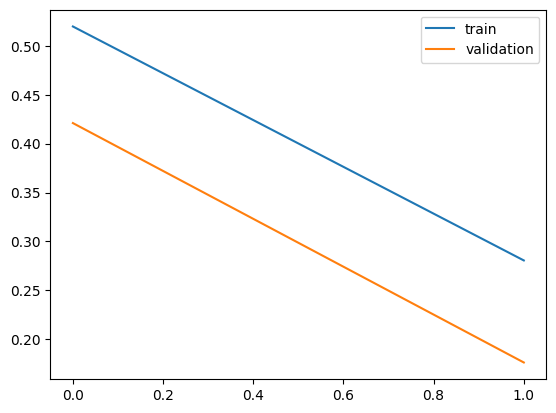

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9354 - loss: 0.1765


# **B. Bài tập**


1.   **Yêu cầu 1 (Tại lớp): Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**
2.   **Yêu cầu 2 (Về nhà): Sinh viên chạy lại tập dữ liệu [CIC IoT dataset 2023](https://www.unb.ca/cic/datasets/iotdataset-2023.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**



